### Motivation and theory

Our aim is to calculate the expectation value and variance of the last layer with activity in a feedforward, layered network as a function of strenth of the weights and the probability of connection between two neurons. This calculation is intended to address a scenario in which connections between neurons have been removed at random, leaving the network in state where the connection probability between two neurons in successive layers is $p_c$.

We begin by assuming connectivity between two successive layers is independent of the connectivity between any other two successive layers. Then the probability of activity terminating at the $m^{th}$ layer is

$$p(m) = (p_l)^m (1 - p_l)$$

where $p_l$ is the probability activity propagates from one layer to the next. We will consider activity as having successively propagated if $p_{t}$ fraction of neurons are active in the subsequent layer. We then have

$$p_l = 1 - \Phi_{1-p_n}(n - n p_{t}, n p_{t} + 1) $$,

where $p_n$ is the probability a single neuron becomes active given a fully active prior layer and where we have used the identity

$$P(X \le k) = \Phi_{1-p}(n - k, k + 1)$$

where $X$ is a binomially distributed random variable of $n$ trials.

We now specify $p_n$ as

$$p_n = 1 - \Phi_{1-p_c}\left(n - \frac{V_{0}}{w}, \frac{V_{0}}{w} + 1\right) $$

where $V_{0}$ is the voltage threshold and $w$ is the strength of all synapses.

We now compute the expectation and variance of final layer with activity in a network of $n_l$ layers. 

$$\mathbb{E}(m) = \sum_{l=1}^{n_l} m \, p(m)$$

$$\mathbb{V}(m) = \sum_{l=1}^{n_l} m^2 p(m)$$

### Computation

In [3]:
%matplotlib inline
from scipy.special import betainc
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


In [38]:
def bin_occurrences(occurrences, min_val=0, max_val=None, bin_size=1):
    scaled_occurrences = ((occurrences - min_val) / bin_size).astype(int)

    if max_val is None:
        max_val = occurrences.max()

    max_idx = int(np.ceil((max_val - min_val) / bin_size)) + 1

    binned = np.zeros(max_idx, dtype=int)
    for i, n in enumerate(scaled_occurrences):
        if n >= max_idx or n < 0:
            continue
            # raise IndexError(f'val {occurrences[i]} is out of bounds for min {min_val} and max {max_val}')
        binned[n] += 1
    return np.arange(max_idx) * bin_size + min_val, binned

In [4]:
layer_width = 20
n_layers = 30

In [92]:
def pr_single_neuron_activation(p_c, v_th, w, layer_width):
    p = 1 - betainc(layer_width - v_th/w, v_th/w + 1, 1 - p_c)
    return p

def pr_percent_layer_activation(p_thresh, p_c, v_th, w, layer_width):
    return 1 - betainc((1 - p_thresh) * layer_width, p_thresh * layer_width + 1, 1 - pr_single_neuron_activation(p_c, v_th, w, layer_width))

def pr_mth_layer_last_active(m, p_thresh, p_c, v_th, w, layer_width):
    p = pr_percent_layer_activation(p_thresh, p_c, v_th, w, layer_width)
    p_m_last_active = np.power(p, m)
    p_m_last_active[:-1] = p_m_last_active[:-1] * (1 - p)
    return p_m_last_active

def expectation_m_layer_survival(p_thresh, p_c, v_th, w, layer_width):
    ms = [m for m in range(0, n_layers)]
    return np.array([np.dot(ms, pr_mth_layer_last_active(ms, p_thresh, p_c, v_th, w_i, layer_width)) for w_i in w])

def variance_m_layer_survival(p_thresh, p_c, v_th, w, layer_width):
    ms = [m for m in range(0, n_layers)]
    moment_2 = np.array([np.dot(np.square(ms), pr_mth_layer_last_active(ms, p_thresh, p_c, v_th, w_i, layer_width)) for w_i in w])
    return moment_2 - np.square(expectation_m_layer_survival(p_thresh, p_c, v_th, w, layer_width))

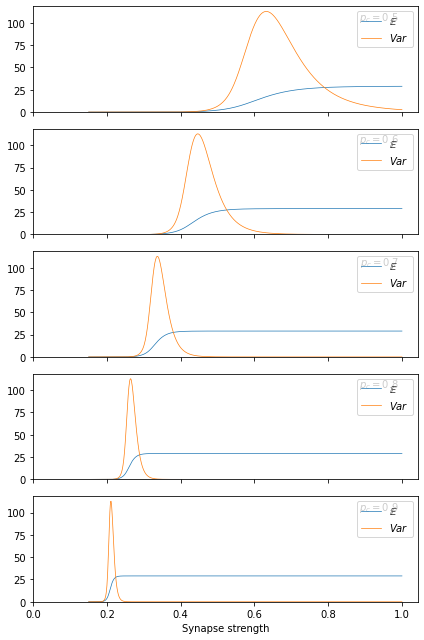

In [93]:
scale = 1.5
fig, axs = plt.subplots(5, 1, sharex=True, sharey=False, figsize=(4 * scale, 6 * scale))

w = np.linspace(0.01, 1, 1000)

for i, p_c in enumerate([0.5, 0.6, 0.7, 0.8, 0.9]):
    axs[i].plot(w, expectation_m_layer_survival(0.9, p_c, 3, w, layer_width), lw=0.7, label=r'$\mathbb{E}$')
    axs[i].plot(w, variance_m_layer_survival(0.9, p_c, 3, w, layer_width), lw=0.7, label=r'$Var$')
    if i == 4:
        axs[i].set_xlabel('Synapse strength')
    axs[i].legend()
    axs[i].set_xlim(0)
    axs[i].set_ylim(0)
    axs[i].text(0.9, 0.9, r'$p_c=$' + str(p_c), horizontalalignment='center', verticalalignment='center', transform=axs[i].transAxes)
fig.tight_layout()

In [24]:
def sim_markov_chain(n_iters, beta=0.1, alpha=0.25):
    p_transitions = beta * np.ones((n_iters, n_layers))
    n_visits = np.zeros((n_iters, n_layers))
    failure_points = np.zeros(n_iters)
    
    for i in range(n_iters):
        k = 0
        while k < n_layers and np.random.rand() < p_transitions[i, k]:
            if i < n_iters - 1:
                p_transitions[i+1, k] = np.minimum(p_transitions[i, k] + alpha, 1)
            n_visits[i, k] += 1
            k += 1
        
        failure_points[i] = k
            
        if i < n_iters - 1:
            n_visits[i+1, :] = n_visits[i, :]
    return p_transitions, n_visits, failure_points

def sim_markov_chain_autonomous(n_iters, beta=0.1, alpha=0.001):
    p_transitions = beta * np.ones((n_iters, n_layers))
    n_visits = np.zeros((n_iters, n_layers))
    failure_points = np.zeros(n_iters)
    
    for i in range(n_iters):
        k = 0
        while k < n_layers and np.random.rand() < p_transitions[i, k]:
            n_visits[i, k] += 1
            k += 1
        
        if i < n_iters - 1:
            p_transitions[i+1, :] = np.minimum(p_transitions[i, :] + alpha, 1)
        
        failure_points[i] = k
            
        if i < n_iters - 1:
            n_visits[i+1, :] = n_visits[i, :]
    return p_transitions, n_visits, failure_points

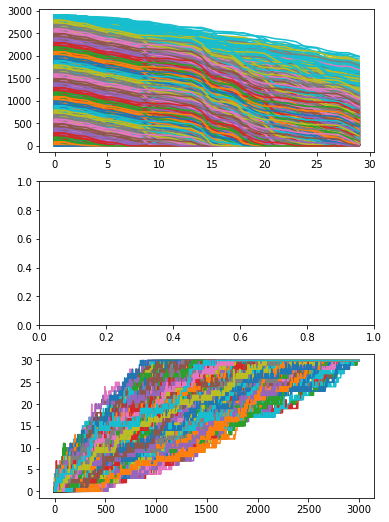

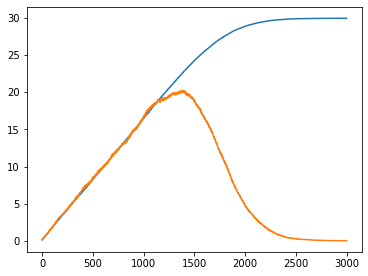

In [80]:
scale = 1.5
fig, axs = plt.subplots(3, 1, sharex=False, sharey=False, figsize=(4 * scale, 6 * scale))

all_failure_points = []

for j in range(2000):
    transitions, visits, failure_points = sim_markov_chain(3000)
    all_failure_points.append(failure_points)
    for i in range(0, visits.shape[0], 100):
        axs[0].plot(np.arange(n_layers), visits[i, :])
    axs[2].plot(np.arange(visits.shape[0]), failure_points)

all_failure_points = np.array(all_failure_points)
    
fig, axs = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(4 * scale, 3 * scale))
axs.plot(np.arange(all_failure_points.shape[1]), np.mean(all_failure_points, axis=0))
axs.plot(np.arange(all_failure_points.shape[1]), np.square(np.std(all_failure_points, axis=0)))

Text(0, 0.5, 'P(m)')

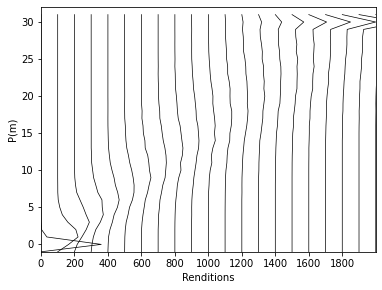

In [87]:
empirical_failure_probs = [bin_occurrences(all_failure_points[:, i].astype(int), min_val=-1, max_val=n_layers + 1)[1] for i in range(all_failure_points.shape[1])]
empirical_failure_probs = np.array(empirical_failure_probs)
empirical_failure_probs = empirical_failure_probs / np.sum(empirical_failure_probs, axis=1).reshape(3000, 1)

fig, axs = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(4 * scale, 3 * scale))
for i in range(0, 3000, 100):
    axs.plot(i * np.ones(empirical_failure_probs.shape[1]) + 400 * empirical_failure_probs[i, :], np.arange(empirical_failure_probs.shape[1]) - 1, lw=0.7, color='black')
axs.set_xticks(np.arange(0, 2000, 200))
axs.set_xticklabels(np.arange(0, 2000, 200))
axs.set_xlim(0, 2000)
axs.set_ylim(-1, n_layers + 2)
axs.set_xlabel('Renditions')
axs.set_ylabel('P(m)')

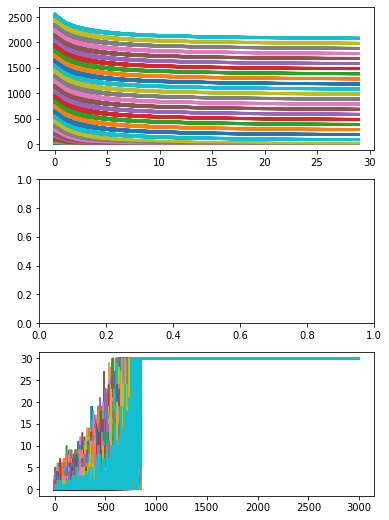

In [69]:
scale = 1.5
fig, axs = plt.subplots(3, 1, sharex=False, sharey=False, figsize=(4 * scale, 6 * scale))

all_failure_points = []

for j in range(2000):
    transitions, visits, failure_points = sim_markov_chain_autonomous(3000, beta=0.15)
    all_failure_points.append(failure_points)
    for i in range(0, visits.shape[0], 100):
        axs[0].plot(np.arange(n_layers), visits[i, :])
    axs[2].plot(np.arange(visits.shape[0]), failure_points)

all_failure_points = np.array(all_failure_points)

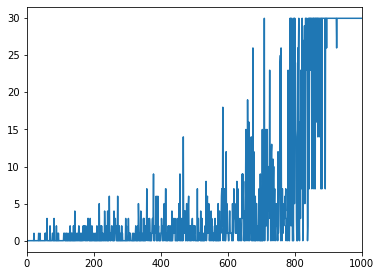

In [110]:
fig, axs = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(4 * scale, 3 * scale))
axs.set_xlim(0, 1000)
# axs.plot(np.arange(all_failure_points.shape[1]), np.mean(all_failure_points, axis=0))
# axs.plot(np.arange(all_failure_points.shape[1]), np.square(np.std(all_failure_points, axis=0)))
for i in np.arange(1):
    axs.plot(np.arange(all_failure_points.shape[1]), all_failure_points[i, :])

Text(0, 0.5, 'P(m)')

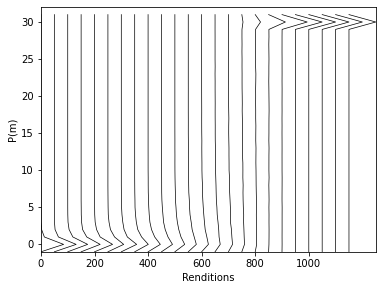

In [104]:
empirical_failure_probs = [bin_occurrences(all_failure_points[:, i].astype(int), min_val=-1, max_val=n_layers + 1)[1] for i in range(all_failure_points.shape[1])]
empirical_failure_probs = np.array(empirical_failure_probs)
empirical_failure_probs = empirical_failure_probs / np.sum(empirical_failure_probs, axis=1).reshape(3000, 1)

fig, axs = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(4 * scale, 3 * scale))
for i in range(0, 1200, 50):
    axs.plot(i * np.ones(empirical_failure_probs.shape[1]) + 100 * empirical_failure_probs[i, :], np.arange(empirical_failure_probs.shape[1]) - 1, lw=0.7, color='black')
axs.set_xticks(np.arange(0, 1200, 200))
axs.set_xticklabels(np.arange(0, 1200, 200))
axs.set_xlim(0, 1250)
axs.set_ylim(-1, n_layers + 2)
axs.set_xlabel('Renditions')
axs.set_ylabel('P(m)')